# Classical $B$ solution domination (Case 3)
_______

### 1) Computing cosmological quantities

- Definition of units and parameters:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
from sympy.solvers import solve
from sympy import Symbol, im
from scipy.special import zeta
from scipy.integrate import odeint
import pandas as pd
from tqdm import tqdm

# Useful for ploting, latex output is turned of
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "monospace",
    "font.monospace": 'Computer Modern'})
plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# UNITS
GeV = pow(10,9) # eV
m = 1/(1.9733*pow(10,-16))*pow(GeV,-1)
kg = 1/1.7827*pow(10,27)*GeV
s = (1/6.5823)*pow(10,25)*pow(GeV,-1)
km = pow(10,3)*m
pc = 3.0857*pow(10,16)*m
Mpc = pow(10,6)*pc
K = 8.621738*pow(10,-5) #eV

# Plank mass
mpl = 1.2209*pow(10,19)*GeV 

# LambaCDM parameters
H0 = 67.4*km/s/Mpc # Hubble parameter
w_r = 2.469*10**(-5) # Amendola pag 15
Om = 0.315 # Omega_matter
h = 67.4/100 # reduced hubble parameter
Or = w_r/(h**2) # Omega_radiation
Ol = 1. - Or - Om # Omega_Lambda

# Hubble parameter evolution
def H(a):
    return H0*np.sqrt(abs(Om*pow(a,-3)+Or*pow(a,-4)+Ol))

- Grid of scale factor:

In [2]:
# Scale factor grid
var_a_len = 1000
a_initial_power = -20
a_final_power = 0
var_a = np.logspace(a_initial_power, a_final_power, base=10, num=var_a_len)


# Computing the age of the universe as a function of the scale factor
def axH(a):
    return 1/(a*H(a))
def t(a):
    quadrature = quad(axH,0,a)
    return quadrature[0]

- Computing cosmological background

In [3]:
# Early universe relations
def trad(T):
    g_star = 109.75
    return 0.301*pow(g_star,-0.5)*mpl/pow(T,2)

def Trad_t(t):
    g_star = 109.75
    return pow(0.301*pow(g_star,-0.5)*mpl/t,0.5)

df = pd.DataFrame([x for x in range(len(var_a))], columns=['ind'])

df['a'] = var_a
df['t'] = [t(a) for a in var_a]
df['T'] = Trad_t(df['t'][0])*df['a'][0]/df['a']
df['H'] = H(df['a'])

- Solving the value of the chemical potential across the evolution of the universe

In [5]:
# Fixed parameters
mf = pow(10,-3) # neutrino mass
gn = 2 # Neutrino internal degrees of freedom
n0 = 339.5*pow(pow(10,-2)*m,-3) # Current number density of neutrinos

# Relax the assymetry for classical solutions to take control of cosmology
dif_c0 = pow(10,-3)*n0 

def solving_mu(a):
    x = Symbol('x')
    F = gn*pow(Trad_t(t(a)),3)/(6*pow(np.pi,2))*(pow(np.pi,2)*x/Trad_t(t(a)) + pow(x/Trad_t(t(a)),3)) - dif_c0*pow(a,-3)
    if im(solve(F,x)[0])!=0:
        print('OJO, imaginary root')
    return float(solve(F,x)[0])

mus = [solving_mu(x) for x in var_a]
df['mu'] = mus
df.to_csv('cosmo_classical_dom.csv')
#df = pd.read_csv('cosmo_classical_dom.csv',header=0,index_col=0)

----

### 2) Computing $\rho_B^{cl.}$

In [6]:
# Parameters of our model
g = pow(10,-9)
MB = pow(10,-2)

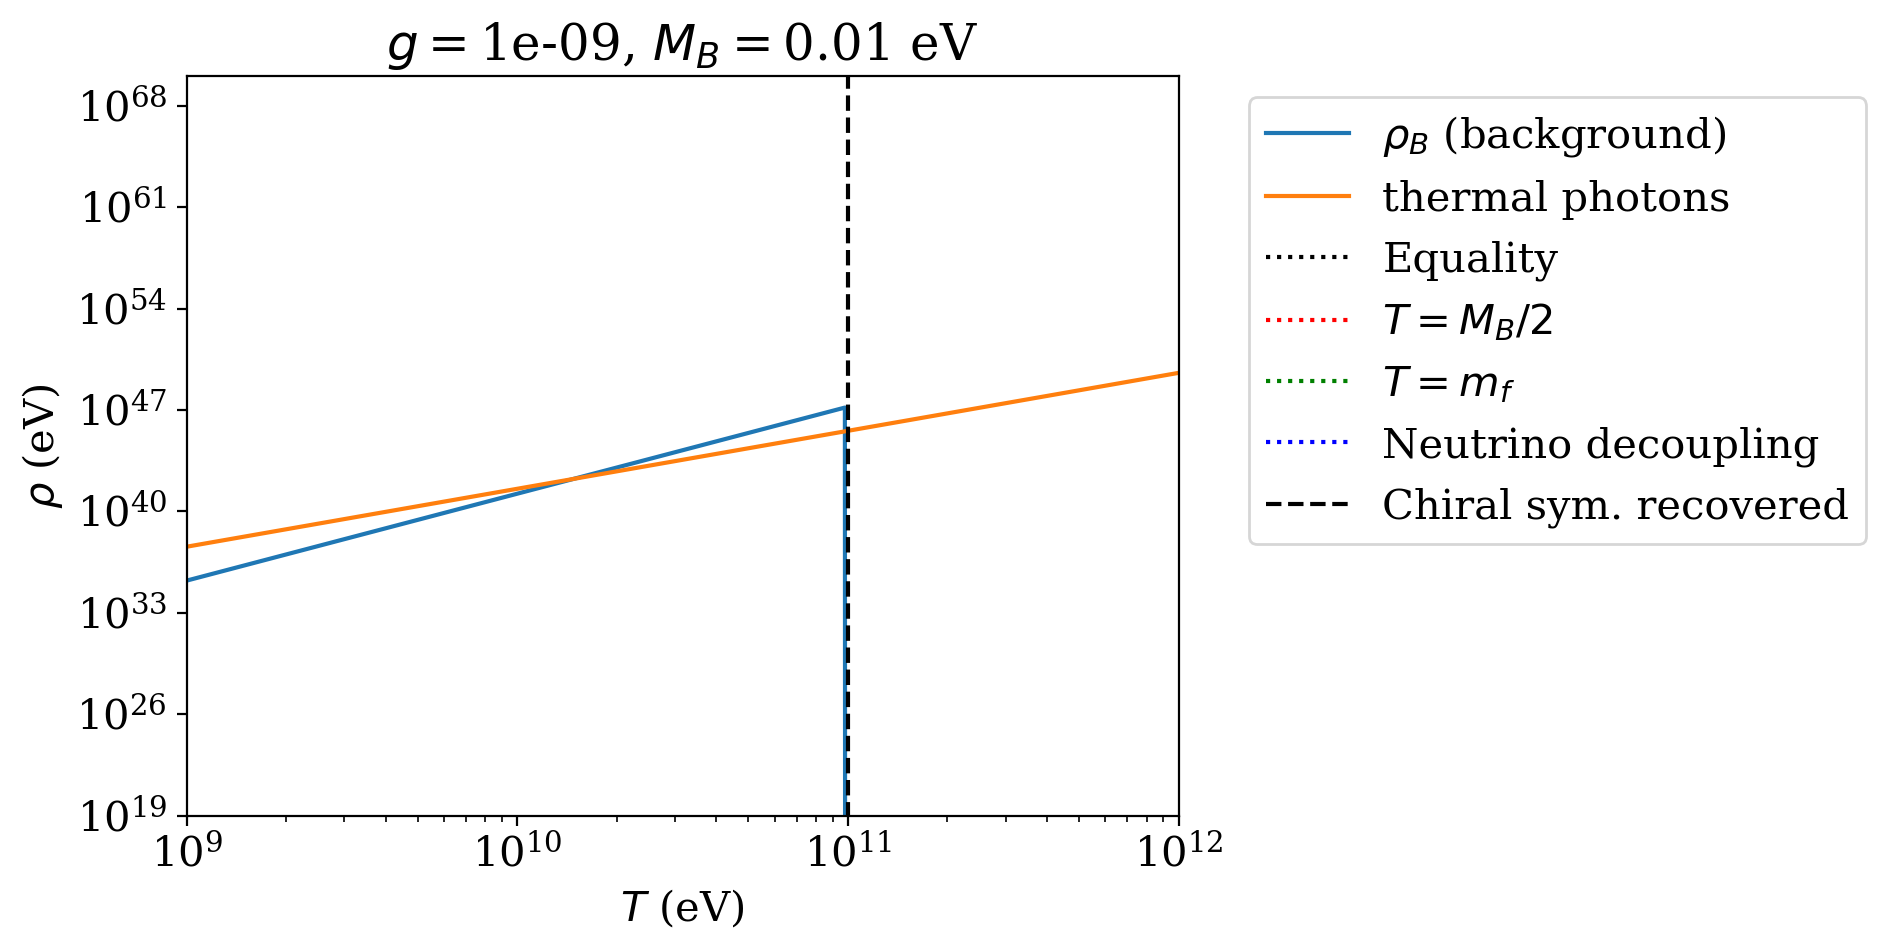

In [12]:
T_chiral = pow(10,11)
T_MB = MB
T_dec = 1.5*pow(10,6)
T_elepos = 0.8*pow(10,6)

# Background component
df['rho_B_back'] = pow(g/MB*dif_c0,2)*pow(df['a'],-6)*(df['T']<T_chiral)

plt.plot(df['T'],df['rho_B_back'], label = '$\\rho_B$ (background)')
plt.plot(df['T'], (pow(np.pi,2)/30*110*pow(df['T'],4)), label='thermal photons')


plt.vlines(pow(10,0),0,pow(10,70),colors='black',linestyles='dotted',label='Equality')
plt.vlines(T_MB,0,pow(10,70),colors='red',linestyles='dotted',label='$T=M_B/2$')
plt.vlines(mf,0,pow(10,70),colors='green',linestyles='dotted',label='$T=m_f$')
plt.vlines(T_dec,0,pow(10,70),colors='blue',linestyles='dotted',label='Neutrino decoupling')
plt.vlines(T_chiral,0,pow(10,70),colors='black',linestyles='dashed',label='Chiral sym. recovered')
plt.ylabel('$\\rho$ (eV)')
plt.xlabel('$T$ (eV)')
plt.xlim(10**9,10**12)
plt.ylim(10**(19))
plt.title('$g=$'+str(g)+', $M_B=$'+str(MB)+' eV')
plt.loglog()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

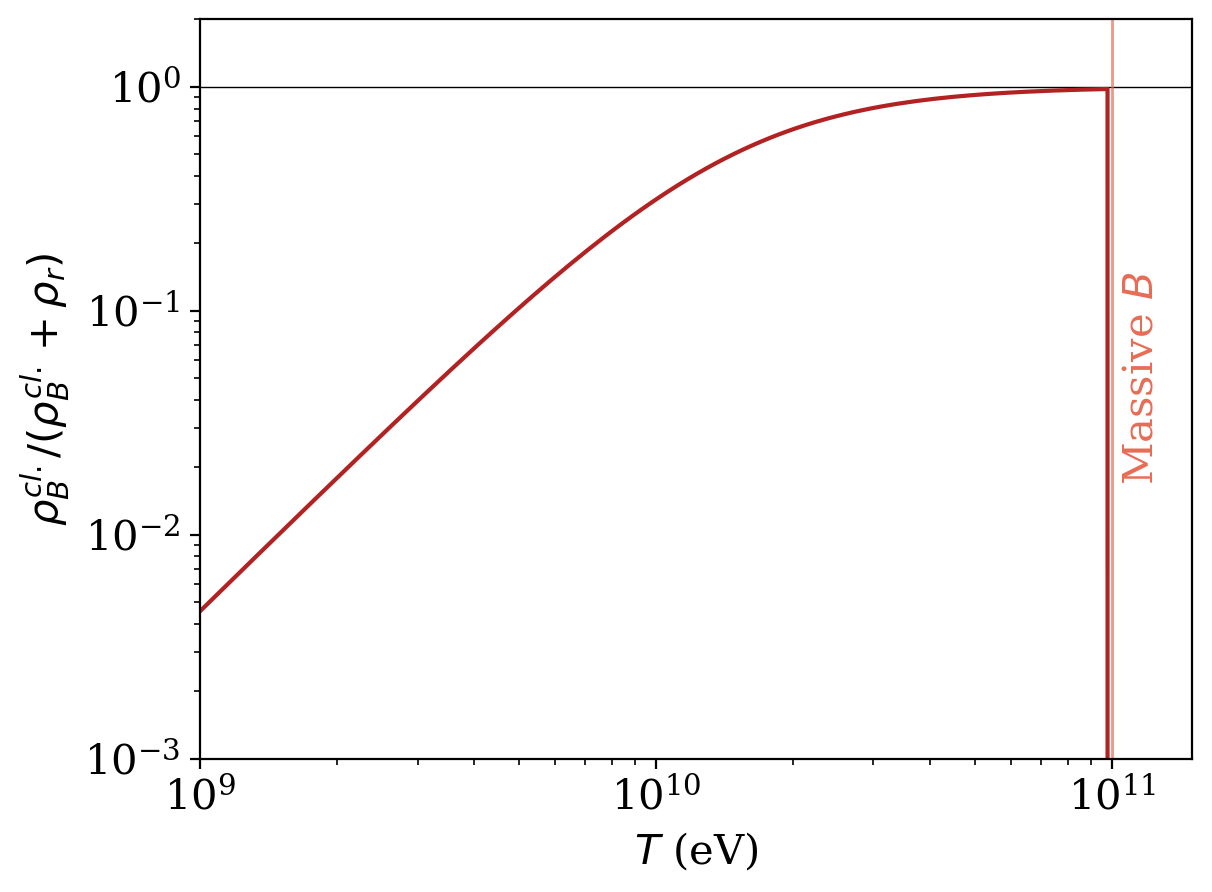

In [13]:
import colormaps as cmaps
from cycler import cycler

colors = [cmaps.matter(i) for i in range(250)][::-1][5::25]

alphal = 0.7
lw = 1
FS = 15

plt.hlines(1,pow(10,9),pow(10,13),colors='k',linestyles='-',lw=0.5)


plt.plot(df['T'], df['rho_B_back']/(pow(np.pi,2)/30*110*pow(df['T'],4) + df['rho_B_back']),
         color='firebrick')

plt.vlines(T_chiral,0,pow(10,20),colors=colors[6],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_chiral*1.05, 0.5*10**(-1), 'Massive $B$', fontsize=FS, rotation=90, color=colors[6], alpha=1, verticalalignment='center')

plt.ylabel('$\\rho_B^{cl.}/(\\rho_B^{cl.}+\\rho_r)$')
plt.xlabel('$T$ (eV)')
plt.xlim(10**9,0.15*10**12)
plt.ylim(10**(-3),2)
plt.loglog()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

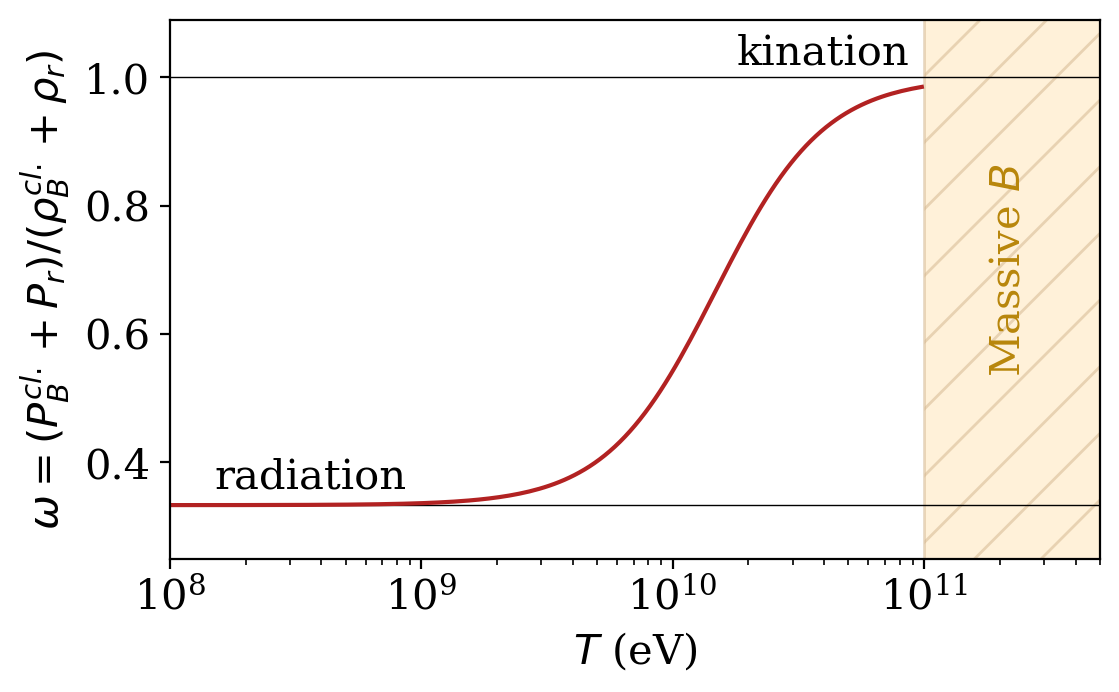

In [18]:
import colormaps as cmaps
from cycler import cycler

colors = [cmaps.matter(i) for i in range(250)][::-1][5::25]

alphal = 0.7
lw = 1
FS = 15

idx_chiral = np.abs(df['T']-T_chiral).idxmin()

# Background B pressure
df['P_B_back'] = df['rho_B_back']

fig = plt.figure(figsize=(6,3.5))
ax = plt.gca()

plt.hlines(1,pow(10,0),pow(10,13),colors='k',linestyles='-',lw=0.5)
plt.text(1.8*10**10, 1.02, 'kination')


plt.hlines(0.33333,pow(10,0),pow(10,13),colors='k',linestyles='-',lw=0.5)
plt.text(1.5*10**8, 1.05*0.34333, 'radiation')


plt.plot(df['T'][idx_chiral:], ((df['P_B_back']+pow(np.pi,2)/90*110*pow(df['T'],4))/(pow(np.pi,2)/30*110*pow(df['T'],4) + df['rho_B_back']))[idx_chiral:],
         color='firebrick')

#plt.vlines(T_chiral,0,pow(10,20),colors=colors[6],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_chiral*1.8, 0.7, 'Massive $B$', fontsize=FS, rotation=90, color='darkgoldenrod', alpha=1, verticalalignment='center')

rect = plt.Rectangle((10**11, 0), 10**(12), 2, facecolor='moccasin', edgecolor='tan', hatch='/', alpha=0.5)
ax.add_patch(rect)

#ax.axvspan(10**11, 10**(12), 0, 3, color='none', linestyle='--', linewidth=2,hatch='//')

plt.ylabel('$\omega = (P_B^{cl.} + P_r)/(\\rho_B^{cl.}+\\rho_r)$')
plt.xlabel('$T$ (eV)')
plt.xlim(10**8,0.5*10**12)
plt.ylim(0.25,1.09)
plt.semilogx()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

fig.savefig('images/classical_EoS.pdf',bbox_inches='tight')

-----